<a href="https://colab.research.google.com/github/AllenForReal/Traffic-Image-Processing-Computer-Vision-/blob/charlie/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')


In [137]:
#from google.colab import drive
#drive.mount('/content/drive')

In [138]:
data_dir = 'E:/DOWNLOAD/archive'
train_path = 'E:/DOWNLOAD/archive/Train'
test_path = 'E:/DOWNLOAD/archive/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [139]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [140]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

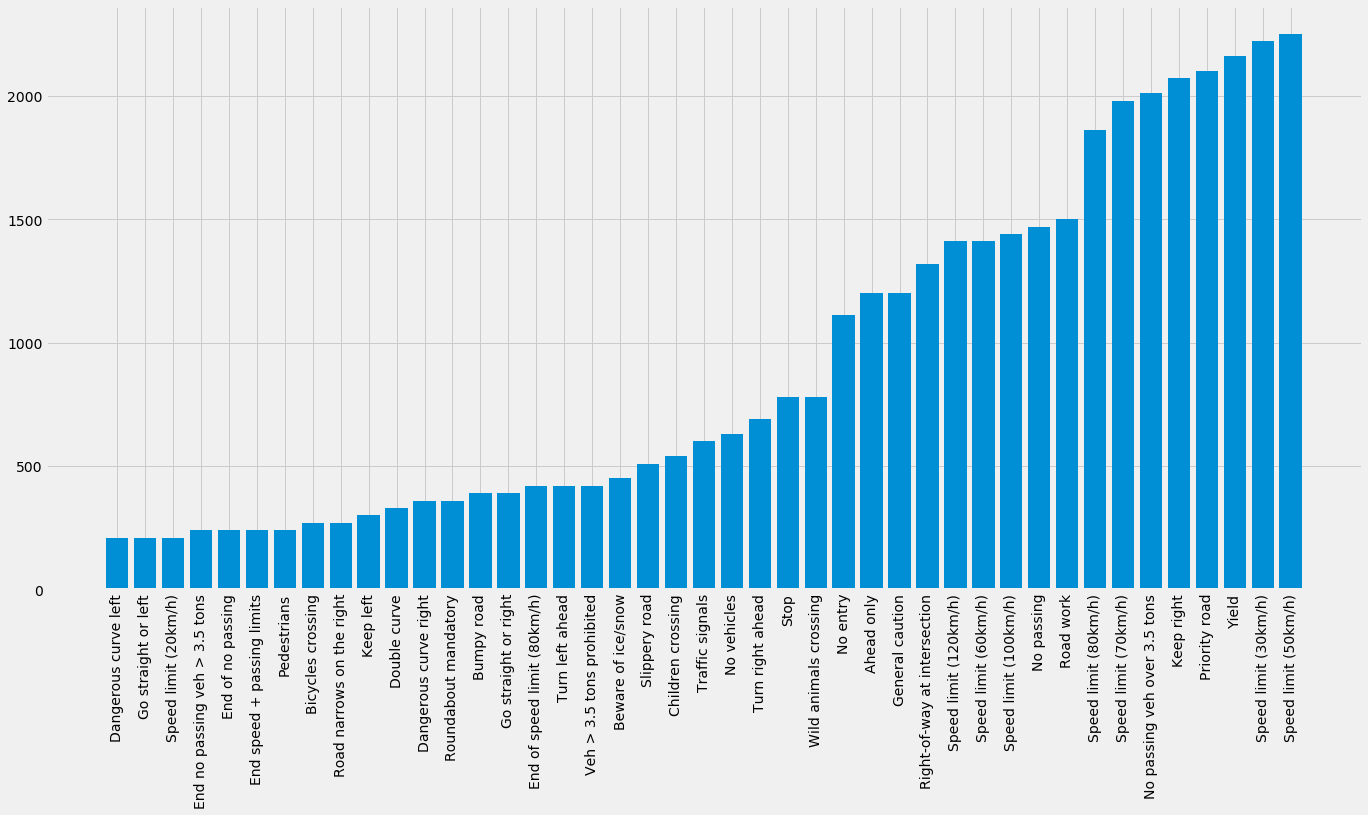

In [141]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

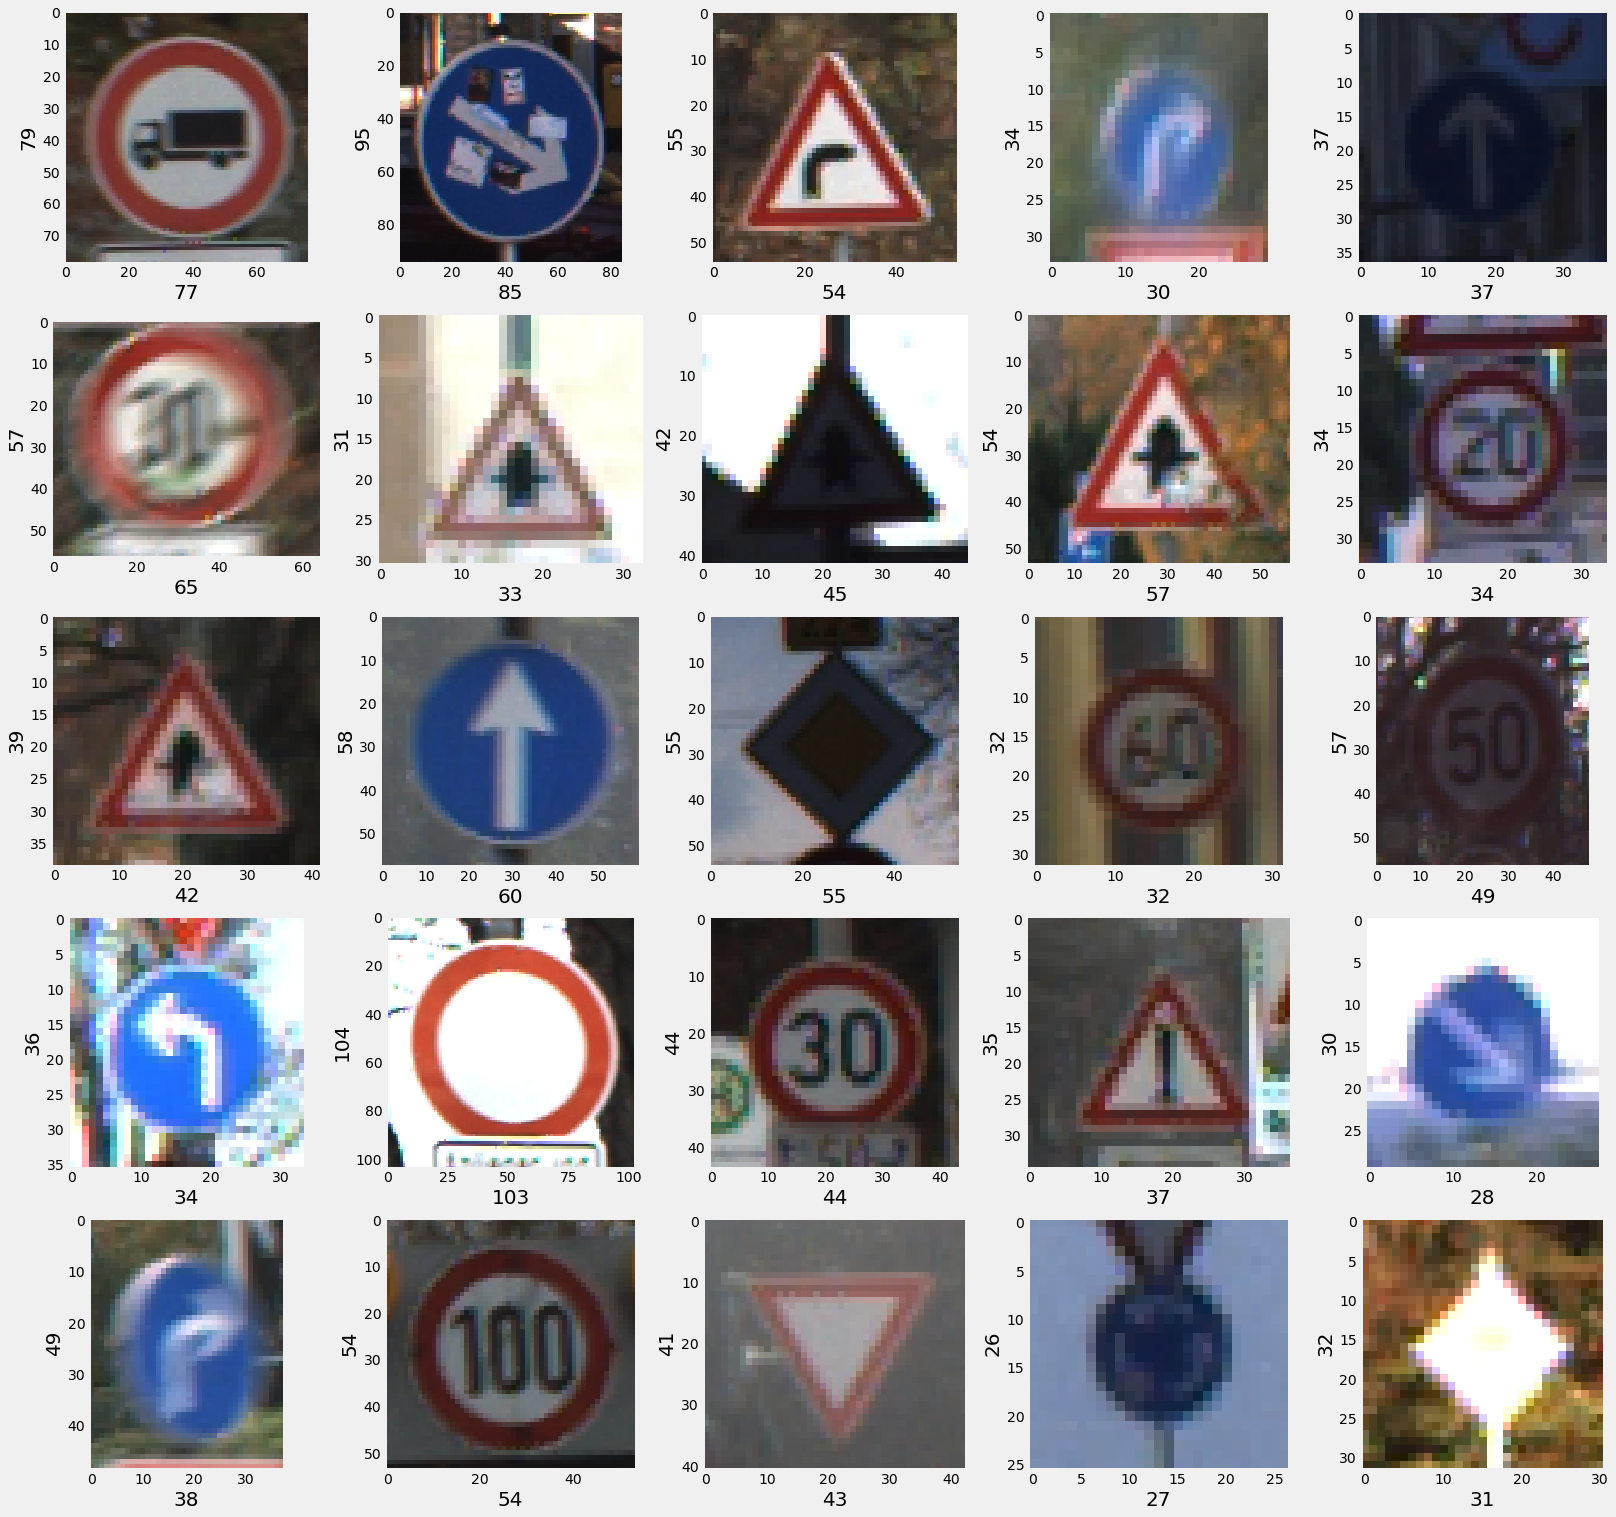

In [142]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [143]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


In [144]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [145]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [146]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [133]:
# model = keras.models.Sequential([    
#     keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
#     keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#     keras.layers.MaxPool2D(pool_size=(2, 2)),
#     keras.layers.BatchNormalization(axis=-1),
    
#     keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
#     keras.layers.MaxPool2D(pool_size=(2, 2)),
#     keras.layers.BatchNormalization(axis=-1),
    
#     keras.layers.Flatten(),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(rate=0.5),
    
#     keras.layers.Dense(43, activation='softmax')
# ])
# print(IMG_HEIGHT,IMG_WIDTH)

32 32


In [182]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
model.add(keras.layers.MaxPool2D((2, 2)))
keras.layers.BatchNormalization(axis=-1),
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(43, activation='softmax'))

In [177]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 14400)             0         
                                                                 
 dense_55 (Dense)            (None, 64)                921664    
                                                                 
 dense_56 (Dense)            (None, 43)                2795      
                                                                 
Total params: 926,251
Trainable params: 926,251
Non-trainable params: 0
_______________________________________________

In [183]:
lr = 0.001
epochs = 10

#opt = tf.keras.optimizers.legacy.Adam(lr=lr, decay=lr / (epochs * 0.5))
opt = tf.keras.optimizers.legacy.Adagrad(lr=lr, decay=lr / (epochs * 0.5))
#opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate = lr, use_locking=False, name='GradientDescent')
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [184]:
#augmenting the data
batch = 16


aug = ImageDataGenerator(
   rotation_range=10,
   zoom_range=0.15,
   width_shift_range=0.1,
   height_shift_range=0.1,
   shear_range=0.15,
   horizontal_flip=False,
   vertical_flip=False,
   fill_mode="nearest")

In [185]:
start = time.time()
history = model.fit(aug.flow(X_train, y_train, batch_size=batch), epochs=epochs, validation_data=(X_val, y_val))
end =  time.time()
print("The total runtime for batch size of",batch,"and", len(model.layers),"number of layers is", end - start)

Epoch 1/10
1716/1716 [==============================] - 16s 9ms/step - loss: 3.5111 - accuracy: 0.0952 - val_loss: 3.3539 - val_accuracy: 0.1726
Epoch 2/10
1716/1716 [==============================] - 15s 9ms/step - loss: 3.3337 - accuracy: 0.1641 - val_loss: 3.2007 - val_accuracy: 0.2133
Epoch 3/10
1716/1716 [==============================] - 15s 9ms/step - loss: 3.2280 - accuracy: 0.1922 - val_loss: 3.0852 - val_accuracy: 0.2255
Epoch 4/10
1716/1716 [==============================] - 17s 10ms/step - loss: 3.1427 - accuracy: 0.2068 - val_loss: 2.9882 - val_accuracy: 0.2457
Epoch 5/10
1716/1716 [==============================] - 16s 9ms/step - loss: 3.0793 - accuracy: 0.2164 - val_loss: 2.9143 - val_accuracy: 0.2719
Epoch 6/10
1716/1716 [==============================] - 15s 9ms/step - loss: 3.0289 - accuracy: 0.2282 - val_loss: 2.8606 - val_accuracy: 0.2682
Epoch 7/10
1716/1716 [==============================] - 16s 9ms/step - loss: 2.9865 - accuracy: 0.2358 - val_loss: 2.8176 - val_a

In [181]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

395/395 [==============================] - 2s 4ms/step
Test Data accuracy:  28.38479809976247


In [158]:
# arr = [128,64,32,16]
# for batch in arr:  
#     start = time.time()
#     model.fit(aug.flow(X_train, y_train, batch_size=batch), epochs=epochs, validation_data=(X_val, y_val))
#     end =  time.time()
    
#     predtrain= model.predict(X_train)
#     classes_xtrain=np.argmax(predtrain,axis=1)
#     train_acc=accuracy_score(y_train["ClassId"].values,classes_xtrain)
    
#     predtest = model.predict(X_val)
#     classes_xtest=np.argmax(predtest,axis=1)
#     test_acc=accuracy_score(y_val["ClassId"].values, classes_xtest)
    
#    print("The total runtime for batch size of",batch,"and", len(model.layers),"number of layers is", end-start)
#     print('Train accuracy：', train_acc)
#     print('Test accuracy：', test_acc)
#     print('')
# print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [159]:
print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

Test Data accuracy:  97.59303246239112


In [24]:
X_train.shape

(27446, 32, 32, 3)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 128)      

In [82]:
# resnet_model =keras.models.Sequential()
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=(32,32,3),
#     pooling='avg',
#     classes=43
# )

tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(32,32,3),
    pooling='avg',
    classes=43,
    classifier_activation='softmax'
)
vgg_model =keras.models.Sequential()

for layer in base_model.layers:
    layer.trainable =False


vgg_model.add(keras.layers.Flatten())
vgg_model.add(keras.layers.Dense(512, activation='relu'))
vgg_model.add(keras.layers.BatchNormalization())
vgg_model.add(keras.layers.Dropout(rate=0.5))
vgg_model.add(keras.layers.Dense(43, activation='softmax'))


58889256/58889256 [==============================] - 1s 0us/step


In [83]:
vgg_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [84]:
batch = 32

start = time.time()
aug = ImageDataGenerator(
   rotation_range=10,
   zoom_range=0.15,
   width_shift_range=0.1,
   height_shift_range=0.1,
   shear_range=0.15,
   horizontal_flip=False,
   vertical_flip=False,
   fill_mode="nearest")

history = vgg_model.fit(aug.flow(X_train, y_train, batch_size=batch), epochs=epochs, validation_data=(X_val, y_val))
end =  time.time()
print("The total runtime for batch size of",batch,"and", len(model.layers),"number of layers is", end - start)

Epoch 1/10
858/858 [==============================] - 12s 14ms/step - loss: 2.9342 - accuracy: 0.2274 - val_loss: 2.3549 - val_accuracy: 0.3440
Epoch 2/10
858/858 [==============================] - 11s 13ms/step - loss: 2.4102 - accuracy: 0.3235 - val_loss: 1.8709 - val_accuracy: 0.4867
Epoch 3/10
858/858 [==============================] - 11s 13ms/step - loss: 2.2625 - accuracy: 0.3582 - val_loss: 1.6936 - val_accuracy: 0.5465
Epoch 4/10
858/858 [==============================] - 12s 13ms/step - loss: 2.1714 - accuracy: 0.3806 - val_loss: 1.5705 - val_accuracy: 0.5605
Epoch 5/10
858/858 [==============================] - 12s 13ms/step - loss: 2.0930 - accuracy: 0.3958 - val_loss: 1.5124 - val_accuracy: 0.5753
Epoch 6/10
858/858 [==============================] - 12s 14ms/step - loss: 2.0492 - accuracy: 0.4065 - val_loss: 1.3908 - val_accuracy: 0.6328
Epoch 7/10
858/858 [==============================] - 11s 13ms/step - loss: 2.0161 - accuracy: 0.4120 - val_loss: 1.3867 - val_accuracy:

In [ ]:
# batch = 32

# start = time.time()
# aug = ImageDataGenerator(
#    rotation_range=10,
#    zoom_range=0.15,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    shear_range=0.15,
#    horizontal_flip=False,
#    vertical_flip=False,
#    fill_mode="nearest")

# history = model.fit(aug.flow(X_train, y_train, batch_size=batch), epochs=epochs, validation_data=(X_val, y_val))
# end =  time.time()
# print("The total runtime for batch size of",batch,"and", len(model.layers),"number of layers is", end - start)

In [ ]:
# inputs = keras.Input(shape=(32, 32, 3))
# x = base_model(inputs)
# x = keras.layers.GlobalAveragePooling2D()(x)
# outputs = keras.layers.Dense(2, activation="softmax")(x)
# model = keras.Model(inputs=inputs, outputs=outputs, name="my_model")
# model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])
# model.summary()

In [129]:
# history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

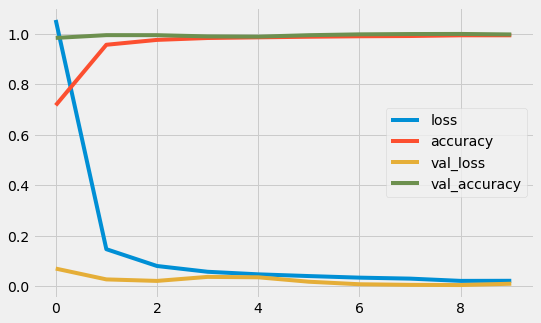

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

In [123]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, classes_x)

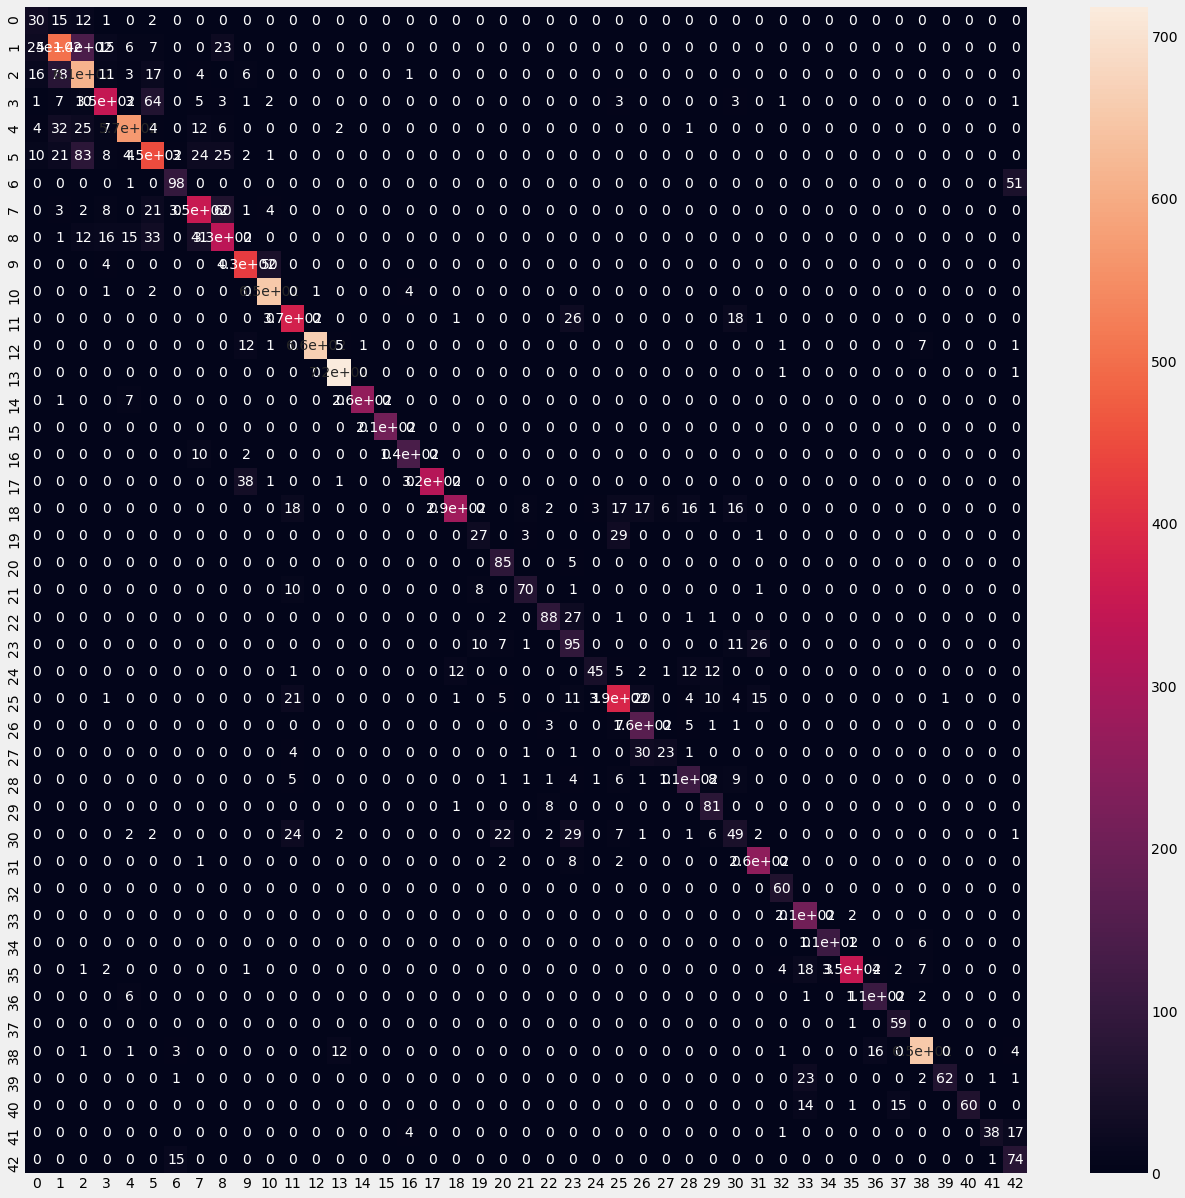

In [124]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [125]:
from sklearn.metrics import classification_report

print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       0.35      0.50      0.41        60
           1       0.76      0.70      0.73       720
           2       0.68      0.82      0.74       750
           3       0.82      0.77      0.80       450
           4       0.92      0.86      0.89       660
           5       0.75      0.71      0.73       630
           6       0.82      0.65      0.73       150
           7       0.78      0.78      0.78       450
           8       0.74      0.74      0.74       450
           9       0.87      0.89      0.88       480
          10       0.92      0.99      0.95       660
          11       0.82      0.89      0.85       420
          12       1.00      0.96      0.98       690
          13       0.97      1.00      0.98       720
          14       1.00      0.97      0.98       270
          15       1.00      1.00      1.00       210
          16       0.94      0.92      0.93       150
          17       1.00    

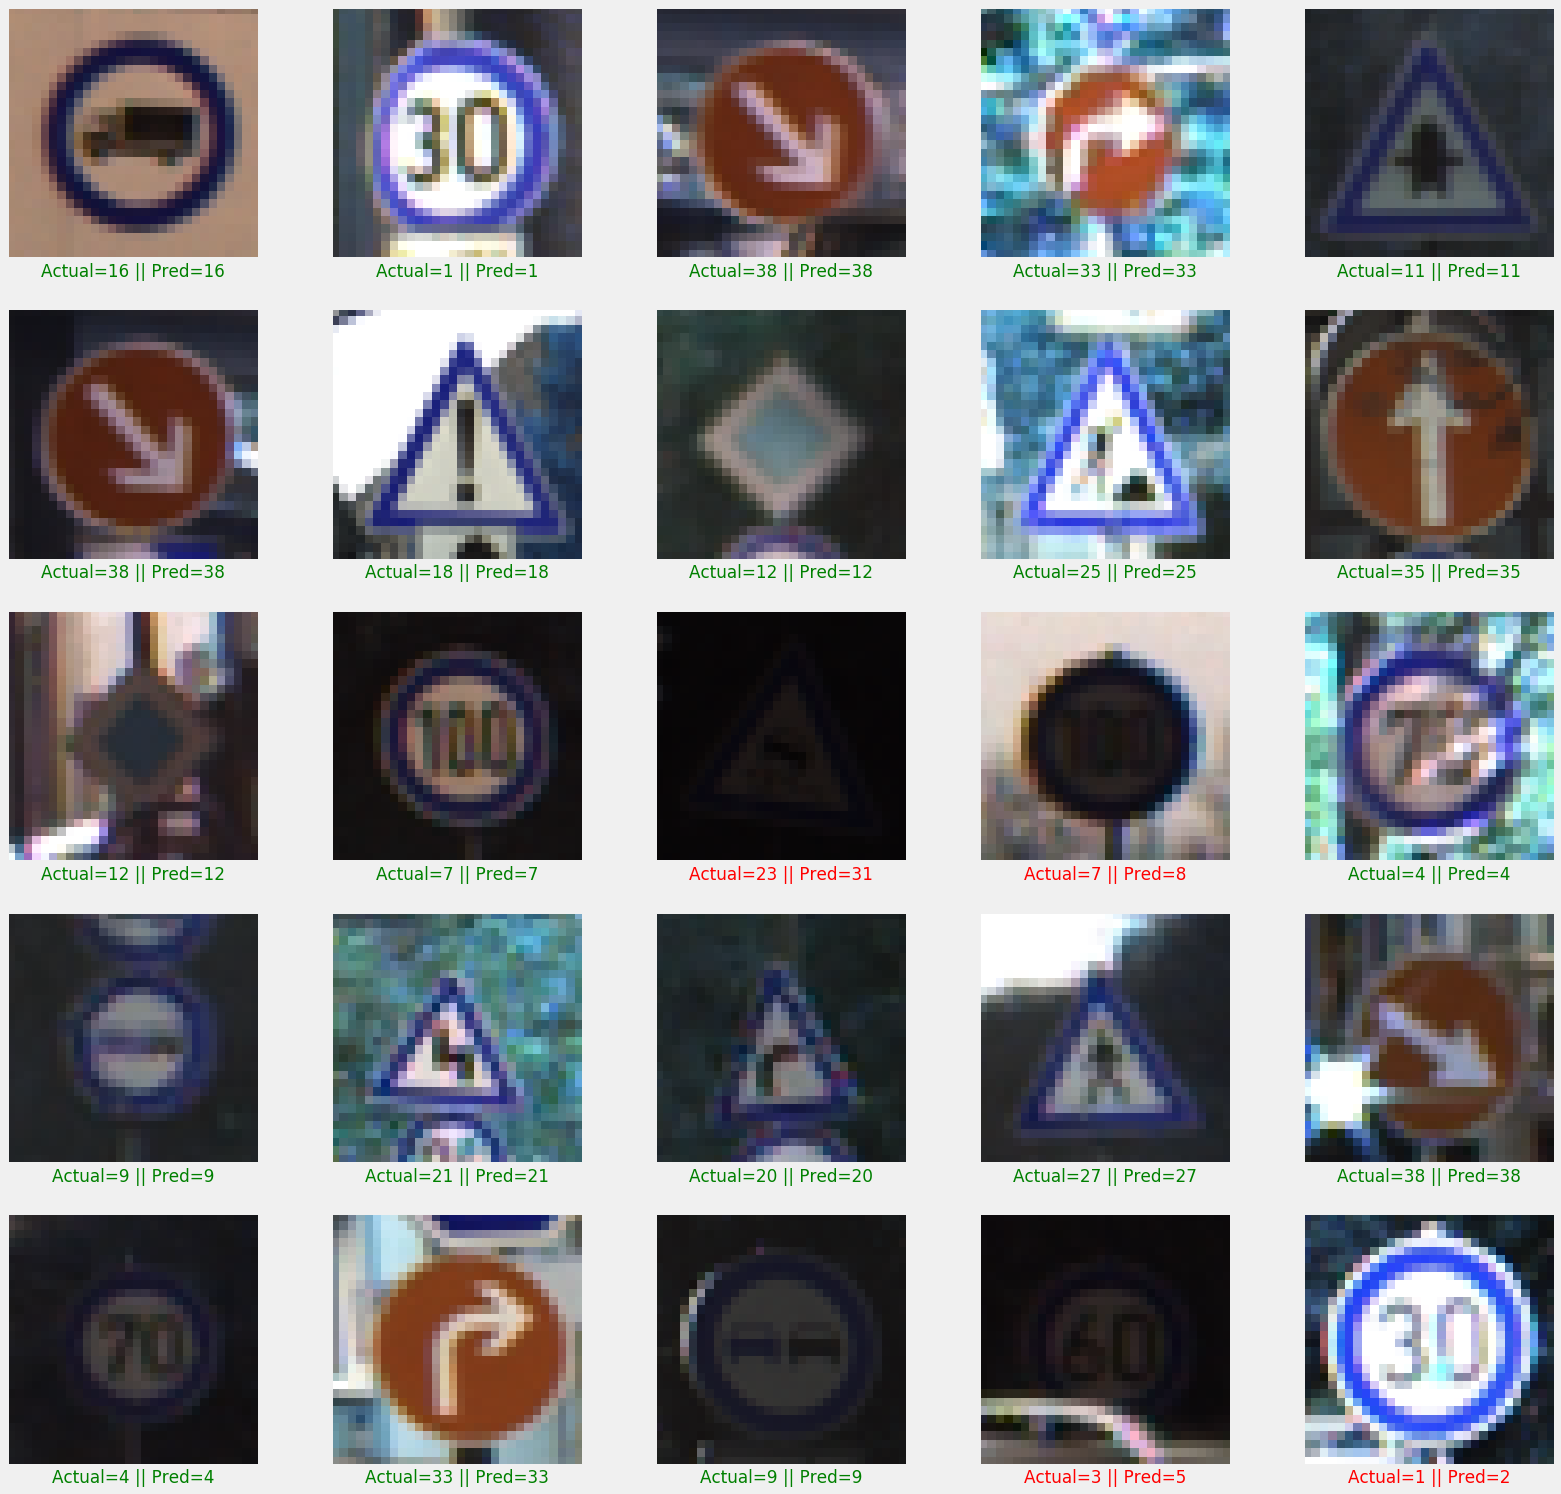

In [126]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes_x[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()